# Introduction

**Team:** Ivana Josipovic, Adrian Miramontes, Ariadna Davila  
**Date:** 3 October 2025

### 5. Use pyIAST (https://pyiast.readthedocs.io/en/latest/) to obtain the binary-mixture isotherms by the linear interpolation method for a pressure range from 0.1 to 4.0. Use increments of 0.2 and plot the results. (6 each)

We first have to import all the functions and files that will be helpful for the calculations and the plotting of the graphs.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast
PRESSURE_COL = "Pressure(bar)"
LOADING_COL  = "Loading(mmol/g)"
df_ch4 = pd.read_csv("CH4_IRMOF1.csv")
df_co2 = pd.read_csv("CO2_IRMOF1.csv")

Here, we can see that the csv file is an isotherm. In the below code cell, we can see the postion of this object in our computer.

In [27]:
ch4_isotherm = pyiast.InterpolatorIsotherm(df_ch4,
                                    loading_key="Loading(mmol/g)",
                                    pressure_key="Pressure(bar)")
print(ch4_isotherm)

However, if we want to visualize the data of this isotherm, we can plot it. 

<Axes: >

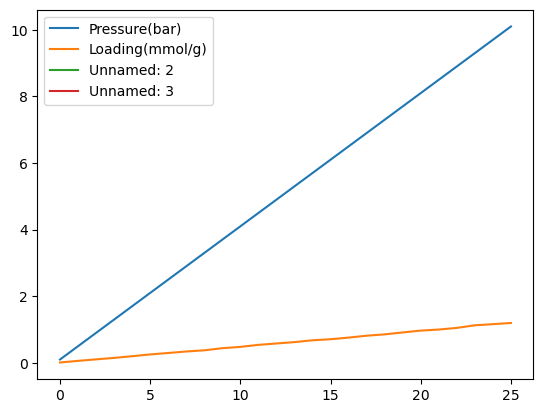

In [28]:
df_ch4.plot()

This preliminary plot confirms that the data set contains the required varibales: pressure and loading. This allows us to create the corresponding adsorption isotherms. 
As a first step, the pure-compound isotherms to observe how each gas behaves as the pressure varies (see cell below).

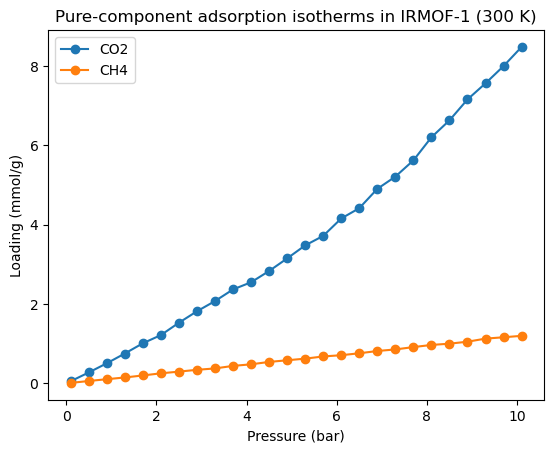

In [39]:
df_co2 = pd.read_csv("CO2_IRMOF1.csv")
df_ch4 = pd.read_csv("CH4_IRMOF1.csv")

plt.plot(df_co2["Pressure(bar)"], df_co2["Loading(mmol/g)"], "o-", label="CO2")
plt.plot(df_ch4["Pressure(bar)"], df_ch4["Loading(mmol/g)"], "o-", label="CH4")
plt.xlabel("Pressure (bar)")
plt.ylabel("Loading (mmol/g)")
plt.legend()
plt.title("Pure-component adsorption isotherms in IRMOF-1 (300 K)")
plt.show()

From the above graph, we can see that the adsorption of both compounds increase monotonically with increasing pressure. However, the isotherm of CO2 increases much faster than the one of CH4.

We can now create a continuous function for each compund by linear interpolation using the above isotherms for the pure compounds and inserting them into the pyiast.InterpolatorIsotherm function.

In [ ]:
co2_iso = pyiast.InterpolatorIsotherm(df_co2, pressure_key=PRESSURE_COL, loading_key=LOADING_COL)
ch4_iso = pyiast.InterpolatorIsotherm(df_ch4, pressure_key=PRESSURE_COL, loading_key=LOADING_COL)

Using the function pyiast.iast(...), which solves the Ideal Adsorbed Solution Theory equations using the previously built interpolated pure-component isotherms (co2_iso, ch4_iso), we tried to plot our results: 
	•	q_co2 – the predicted adsorbed loading of CO₂ (mmol/g)
	•	q_ch4 – the predicted adsorbed loading of CH₄ (mmol/g)

In [47]:
p_list = np.arange(0.1, 4.001, 0.2)
y_co2_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.9]
results = []   # store all outputs
for y in y_co2_list:
    for P in p_list:
        partials = [y * P, (1-y) * P]
        q_co2, q_ch4 = pyiast.iast(partials, [co2_iso, ch4_iso])
        results.append({
            "P (bar)": P,
            "y_CO2": y,
            "q_CO2": q_co2,
            "q_CH4": q_ch4
        })
df_mix = pd.DataFrame(results)
print(df_mix.head())

Exception: To compute the spreading pressure at this bulk
            gas pressure, we would need to extrapolate the isotherm since this
            pressure is outside the range of the highest pressure in your
            pure-component isotherm data, 10.100000.

            At present, your InterpolatorIsotherm object is set to throw an
            exception when this occurs, as we do not have data outside this
            pressure range to characterize the isotherm at higher pressures.

            Option 1: fit an analytical model to extrapolate the isotherm
            Option 2: pass a `fill_value` to the construction of the
                InterpolatorIsotherm object. Then, InterpolatorIsotherm will
                assume that the uptake beyond pressure 10.100000 is equal to
                `fill_value`. This is reasonable if your isotherm data exhibits
                a plateau at the highest pressures.
            Option 3: Go back to the lab or computer to collect isotherm data
                at higher pressures. (Extrapolation can be dangerous!)

However, this did not work since it gave us an error value saying that at least one pure-component isotherm did not extend to sufficiently high pressure for the conditions being solved (IAST can require internal pressures \(p_i^\*\) higher than the simple partial pressures).
This means that we can either collect more data, set a plateau at the highest value or remain interpolation-only by restricting the total-pressure grid for each composition so that all required pressures stay within the measured ranges.
Since there is no possibility of collecting more data, and the second option is an extrapolation, we followed the exercise instructions and applied the last method. As a result, some curves terminate below 4 bar by design, ensuring no extrapolation is used.

y_CO2=0.10 -> allowed Pmax ≈ 11.222 bar
y_CO2=0.20 -> allowed Pmax ≈ 12.625 bar
y_CO2=0.40 -> allowed Pmax ≈ 16.833 bar
y_CO2=0.50 -> allowed Pmax ≈ 20.200 bar
y_CO2=0.60 -> allowed Pmax ≈ 16.833 bar
y_CO2=0.80 -> allowed Pmax ≈ 12.625 bar
Computed 92 points total.


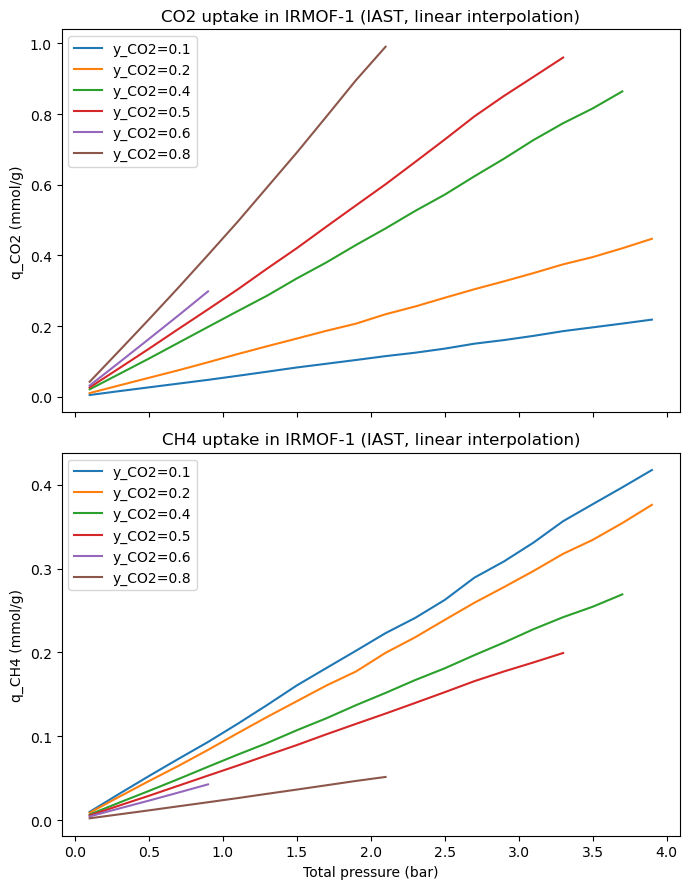

In [50]:
#composition set for 6 curves 
y_co2_list = [0.10, 0.20, 0.40, 0.50, 0.60, 0.80]  

P_MIN, P_MAX_TARGET, P_STEP = 0.1, 4.0, 0.2
Pmax_co2 = float(df_co2[PRESSURE_COL].max())
Pmax_ch4 = float(df_ch4[PRESSURE_COL].max())

#compute largest total pressure of CO2 (y) and CH4 (1-y) without leaving pressure frame
def allowed_Pmax_for_y(y, Pmax_co2, Pmax_ch4):
    if y <= 0:  return Pmax_ch4
    if y >= 1:  return Pmax_co2
    return min(Pmax_co2 / y, Pmax_ch4 / (1 - y))

#build pressure array (grid) for one composition
def make_P_grid(Pmax_allowed, Pmin=P_MIN, Pmax_target=P_MAX_TARGET, Pstep=P_STEP):
    Pmax = min(Pmax_target, Pmax_allowed)
    if Pmax < Pmin: return np.array([])
    n = int(np.floor((Pmax - Pmin) / Pstep)) + 1
    return Pmin + np.arange(n) * Pstep

#checks allowable Pmax per composition
for y in y_co2_list:
    print(f"y_CO2={y:.2f} -> allowed Pmax ≈ {allowed_Pmax_for_y(y, Pmax_co2, Pmax_ch4):.3f} bar")

#IAST loop (stop a curve at first failure, stays within interpolation)
results = []
for y in y_co2_list:
    Pgrid = make_P_grid(allowed_Pmax_for_y(y, Pmax_co2, Pmax_ch4))
    for P in Pgrid:
        partials = [y * P, (1 - y) * P]  #order: [co2_iso, ch4_iso]
        try:
            #predicts adsorbed loading of CO2 and CH4 with IAST
            q_co2, q_ch4 = pyiast.iast(
                partials,
                [co2_iso, ch4_iso],
                adsorbed_mole_fraction_guess=[y, 1 - y]
            )
        except Exception:
            #once it fails at a higher P, lower points are already collected; break this y
            break
        results.append({
            "P (bar)": P,
            "y_CO2": y,
            "q_CO2 (mmol/g)": q_co2,
            "q_CH4 (mmol/g)": q_ch4
        })

df_mix = pd.DataFrame(results)
print(f"Computed {len(df_mix)} points total.")
df_mix.head()

#plot
fig, axs = plt.subplots(2, 1, figsize=(7, 9), sharex=True)

for y in y_co2_list:
    sub = df_mix[df_mix["y_CO2"] == y].sort_values("P (bar)")
    if sub.empty:
        continue
    axs[0].plot(sub["P (bar)"], sub["q_CO2 (mmol/g)"], label=f"y_CO2={y}")
    axs[1].plot(sub["P (bar)"], sub["q_CH4 (mmol/g)"], label=f"y_CO2={y}")

axs[0].set_ylabel("q_CO2 (mmol/g)")
axs[0].set_title("CO2 uptake in IRMOF-1 (IAST, linear interpolation)")
axs[0].legend()

axs[1].set_xlabel("Total pressure (bar)")
axs[1].set_ylabel("q_CH4 (mmol/g)")
axs[1].set_title("CH4 uptake in IRMOF-1 (IAST, linear interpolation)")
axs[1].legend()

plt.tight_layout()
plt.show()

From the above graphs it is possible to discuss the gas uptake of both CO₂ and CH₄.  
As already observed in the pure-component isotherms, CO₂ shows a stronger adsorption than CH₄, and this behavior is again evident when the gases are mixed.  
While the adsorbed amounts of both gases increase with increasing pressure, the uptake of CH₄ rises more slowly, reflecting the weaker interaction of CH₄ with the IRMOF-1 framework.

### 6. Calculate the selectivity of CO2 over CH4 at 0.1, 1, 2 and 3 bars and 300 K (2 each). What can you deduce ? (2)

In order to compute the selectivity, the following formula is used:

$S = \dfrac{x_{CO_2}/x_{CH_4}}{y_{CO_2}/y_{CH_4}}$.

Using the mixutre results df_mix, we can compute the selectivities of CO2 over CH4 at different pressures.

In [ ]:
df_sel = df_mix.copy()
df_sel["q_tot"]  = df_sel["q_CO2 (mmol/g)"] + df_sel["q_CH4 (mmol/g)"]
df_sel["x_CO2"]  = df_sel["q_CO2 (mmol/g)"] / df_sel["q_tot"]
df_sel["x_CH4"]  = df_sel["q_CH4 (mmol/g)"] / df_sel["q_tot"]
df_sel["y_CH4"]  = 1.0 - df_sel["y_CO2"]
df_sel["S_CO2_CH4"] = (df_sel["x_CO2"]/df_sel["x_CH4"]) / (df_sel["y_CO2"]/df_sel["y_CH4"])

pressures = [0.1, 1.0, 2.0, 3.0]

#selectivity for all compositions at the requested pressures
out = (df_sel[df_sel["P (bar)"].isin(pressures)]
       .sort_values(["P (bar)", "y_CO2"])[["P (bar)","y_CO2","S_CO2_CH4"]])
display(out)

,P (bar),y_CO2,S_CO2_CH4
0,0.1,0.1,4.910589
20,0.1,0.2,4.869511
40,0.1,0.4,4.798190
59,0.1,0.5,4.769926
76,0.1,0.6,4.745668
81,0.1,0.8,4.706345


### 7. Prove that if yCO2 drops to 0.2, the selectivity doesn’t change (8). What should we do to test if the selectivity is a function of temperature ? (4)

For this exercise, we need to look at Henry's Law, which is given by the following formula:
$q_i = H_ip_i$
where H_i is the Henry constant of component $i$ at temperature $T$.
This is the low-pressure (Henry) regime, where each pure isotherm is linear.


For a binary gas at total pressure $P$ and gas-phase fractions 
$y_{\mathrm{CO_2}}$ and $y_{\mathrm{CH_4}}=1-y_{\mathrm{CO_2}}$

$q_{\mathrm{CO_2}} = H_{\mathrm{CO_2}}\, y_{\mathrm{CO_2}} P,
\qquad
q_{\mathrm{CH_4}} = H_{\mathrm{CH_4}}\, (1-y_{\mathrm{CO_2}}) P.$

The adsorbed-phase mole fractions are

$x_{\mathrm{CO_2}}=\frac{q_{\mathrm{CO_2}}}{q_{\mathrm{CO_2}}+q_{\mathrm{CH_4}}},
\qquad
x_{\mathrm{CH_4}}=\frac{q_{\mathrm{CH_4}}}{q_{\mathrm{CO_2}}+q_{\mathrm{CH_4}}}.$

Hence

$\frac{x_{\mathrm{CO_2}}}{x_{\mathrm{CH_4}}}
= \frac{H_{\mathrm{CO_2}}\, y_{\mathrm{CO_2}}}{H_{\mathrm{CH_4}}\, (1-y_{\mathrm{CO_2}})}.$

The selectivity is

$S_{\mathrm{CO_2/CH_4}}
= \frac{\dfrac{x_{\mathrm{CO_2}}}{x_{\mathrm{CH_4}}}}
       {\dfrac{y_{\mathrm{CO_2}}}{y_{\mathrm{CH_4}}}}
= \frac{H_{\mathrm{CO_2}}}{H_{\mathrm{CH_4}}}.$

Because $S_{\mathrm{CO_2/CH_4}}$ depends only on the ratio of Henry constants,
it is independent of $y_{\mathrm{CO_2}}$.
Therefore lowering $y_{\mathrm{CO_2}}$ to $0.2$ does not change the selectivity
(as long as the system remains in the Henry regime).

In order to test whether $S_{\mathrm{CO_2/CH_4}}$ varies with temperature, we first measure the pure-component isotherms at several temperatures to extract Henry's constants
\
\
   $H_{\mathrm{CO_2}}(T)$ and $H_{\mathrm{CH_4}}(T)$.

Then, we compute $S(T)$ in the Henry regime.
   \
   \
   $S_{\mathrm{CO_2/CH_4}}(T)
   = \frac{H_{\mathrm{CO_2}}(T)}{H_{\mathrm{CH_4}}(T)}.$
   

Afterwards, we check the finite pressures and run the IAST at fixed $P$ and composition $y$ using
the temperature-specific pure isotherms and compare $S(T)$.

Finally, we interpret the thermodinamical values by plotting 
   $\ln H_i$ versus $1/T$ that gives a line of slope
   \
   \
   $-\Delta H_i/R$.  
   \
   Different slopes for CO₂ and CH₄ imply that
   \
   \
   $H_{\mathrm{CO_2}}/H_{\mathrm{CH_4}}$ 
   \
   \
   and hence $S$ change with $T$.

### 8. Explain if IRMOF-1 is a good or bad candidate for CH4 storage. (10)

IRMOF-1 is not a good candidate for CH₄ storage.
There are three reasons why:

1) The uptake of CH₄ is low, which can be seen by the pure-component and mixture isotherms. They  show that CH₄ loading in IRMOF-1 stays relatively small, even as pressure increases.
This is a problem when it comes to the storage of the gas, since the total CH₄ capacity would remain well below the required values.

2) Methane interacts only through weak Van der Waals forces with the MOF’s pore walls.
IRMOF-1 does not have the open metal sites or any polar functional groups that create strong binding and high isosteric heats of adsorption. Thus, it cannot pack methane densely at room temperature.

1) In a CO₂/CH₄ mixture (like raw natural gas), CO₂ is a way better candidate than CH₄ for adsorption sites, which then also lowers the effective methane capacity.

Because of these factors, IRMOF-1 cannot meet the high working capacity and energy efficiency targets that are needed for methane storage.
It is therefore unsuitable as a CH₄ storage material.